# Deep Imputation of BraTS dataset with MONAI

The dataset comes from http://medicaldecathlon.com/.  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: **Drop some of the modalities randomly and reconstruct it by imputing with a 3D U-Net**

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
# !python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.3 MB/s eta 0:00:00


## Setup imports

In [2]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
# import onnxruntime
from tqdm import tqdm

import torch

print_config()

MONAI version: 1.4.dev2440
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c2bfe29203f3a82b689d3f1d5334e484f6fbb1a6
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
# os.environ["MONAI_DATA_DIRECTORY"] = "/scratch1/sachinsa/monai_data_1"
from google.colab import drive
drive.mount('/content/drive')
os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/Research/deep_imputation"

Mounted at /content/drive


In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/Research/deep_imputation


In [6]:
# # write monai transform to make random channels zero / -ve

# from monai.transforms import RandomizableTransform, MapTransform, LazyTransform

# class RandomDropd(RandomizableTransform, MapTransform, LazyTransform):
#     """
#     Randomly make

#     """
#     def __init__(
#         self,
#         #keys: KeysCollection,
#         prob: float = 0.25,
#         allow_missing_keys: bool = False,
#         lazy: bool = False,
#     ) -> None:
#         MapTransform.__init__(self, keys, allow_missing_keys)
#         RandomizableTransform.__init__(self, prob)
#         LazyTransform.__init__(self, lazy=lazy)
#         self.dropper = Drop(channels=[], lazy=lazy)

#     @LazyTransform.lazy.setter  # type: ignore
#     def lazy(self, val: bool):
#         self.flipper.lazy = val
#         self._lazy = val

#     def set_random_state(self, seed: int | None = None, state: np.random.RandomState | None = None) -> RandFlipd:
#         super().set_random_state(seed, state)
#         return self

#     def __call__(self, data: Mapping[Hashable, torch.Tensor], lazy: bool | None = None) -> dict[Hashable, torch.Tensor]:
#         """
#         Args:
#             data: a dictionary containing the tensor-like data to be processed. The ``keys`` specified
#                 in this dictionary must be tensor like arrays that are channel first and have at most
#                 three spatial dimensions
#             lazy: a flag to indicate whether this transform should execute lazily or not
#                 during this call. Setting this to False or True overrides the ``lazy`` flag set
#                 during initialization for this call. Defaults to None.

#         Returns:
#             a dictionary containing the transformed data, as well as any other data present in the dictionary
#         """
#         d = dict(data)
#         self.randomize(None)

#         lazy_ = self.lazy if lazy is None else lazy
#         for key in self.key_iterator(d):
#             if self._do_transform:
#                 d[key] = self.flipper(d[key], lazy=lazy_)
#             else:
#                 d[key] = convert_to_tensor(d[key], track_meta=get_track_meta())
#             self.push_transform(d[key], replace=True, lazy=lazy_)
#         return d

#     def inverse(self, data: Mapping[Hashable, torch.Tensor]) -> dict[Hashable, torch.Tensor]:
#         d = dict(data)
#         for key in self.key_iterator(d):
#             xform = self.pop_transform(d[key])
#             if not xform[TraceKeys.DO_TRANSFORM]:
#                 continue
#             with self.flipper.trace_transform(False):
#                 d[key] = self.flipper(d[key])
#         return d



## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Experiment with transforms (temp code)
To develop Drop functionality

In [ ]:
# train_transform = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys="image"),
#         EnsureTyped(keys=["image", "label"]),
#         RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
#     ]
# ) # for development


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    # transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)

# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

In [ ]:
train_ds_1 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    # transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)

train_ds_2 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)

2024-10-11 03:42:37,420 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-10-11 03:42:37,424 - INFO - File exists: /content/drive/MyDrive/Research/deep_imputation/Task01_BrainTumour.tar, skipped downloading.
2024-10-11 03:42:37,428 - INFO - Non-empty folder exists in /content/drive/MyDrive/Research/deep_imputation/Task01_BrainTumour, skipped extracting.


In [76]:
import numpy as np

def generate_boolean_list():
    while True:
        # np.random.seed(42)
        # Generate a boolean array where each entry is True with 20% probability
        bool_array = np.random.rand(4) < 0.2

        # Check if at least one value is False
        if not np.all(bool_array):
            return np.where(bool_array)[0].tolist()

true_indices = generate_boolean_list()
print("Indices where True:", true_indices)

Indices where True: [1]


image shape: torch.Size([4, 224, 224, 144])


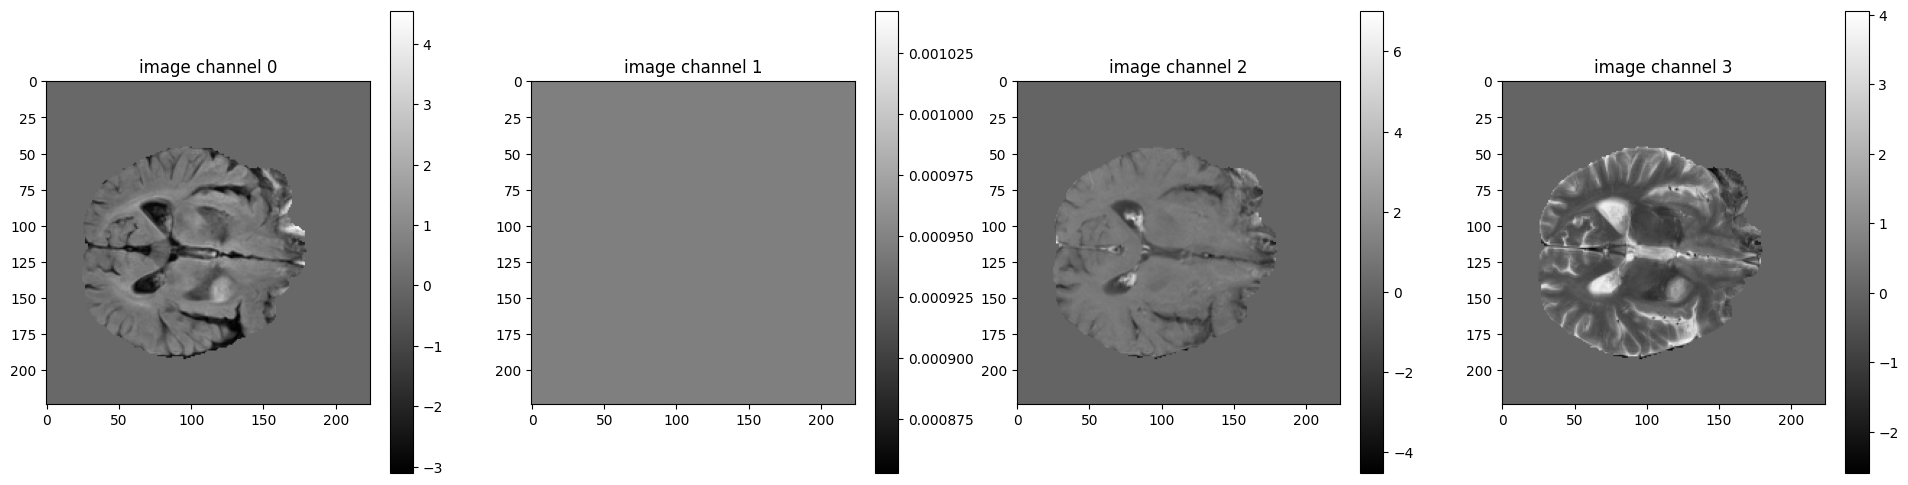

In [80]:

val_data_example = train_ds_1[1]['image']
print(f"image shape: {val_data_example.shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i, :, :, 60].detach().cpu(), cmap="gray")
    plt.colorbar()
plt.show()

image shape: torch.Size([4, 224, 224, 144])


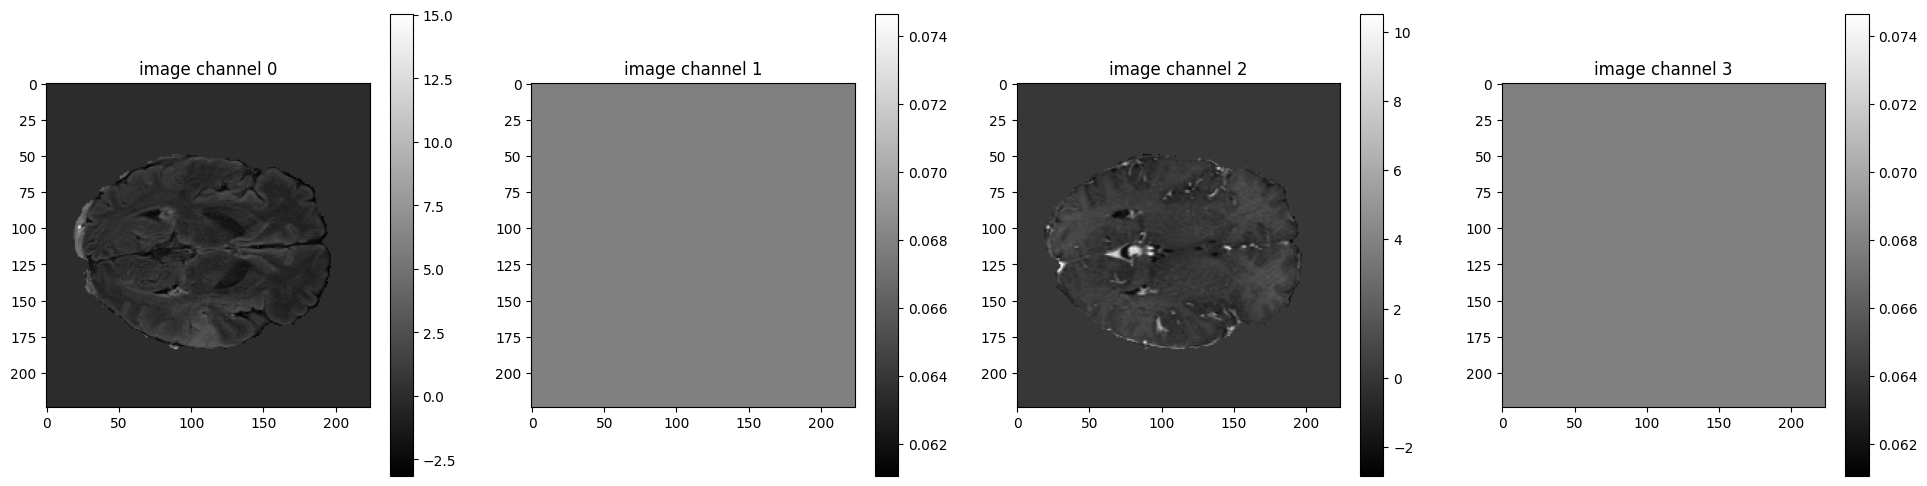

image shape: torch.Size([4, 224, 224, 144])


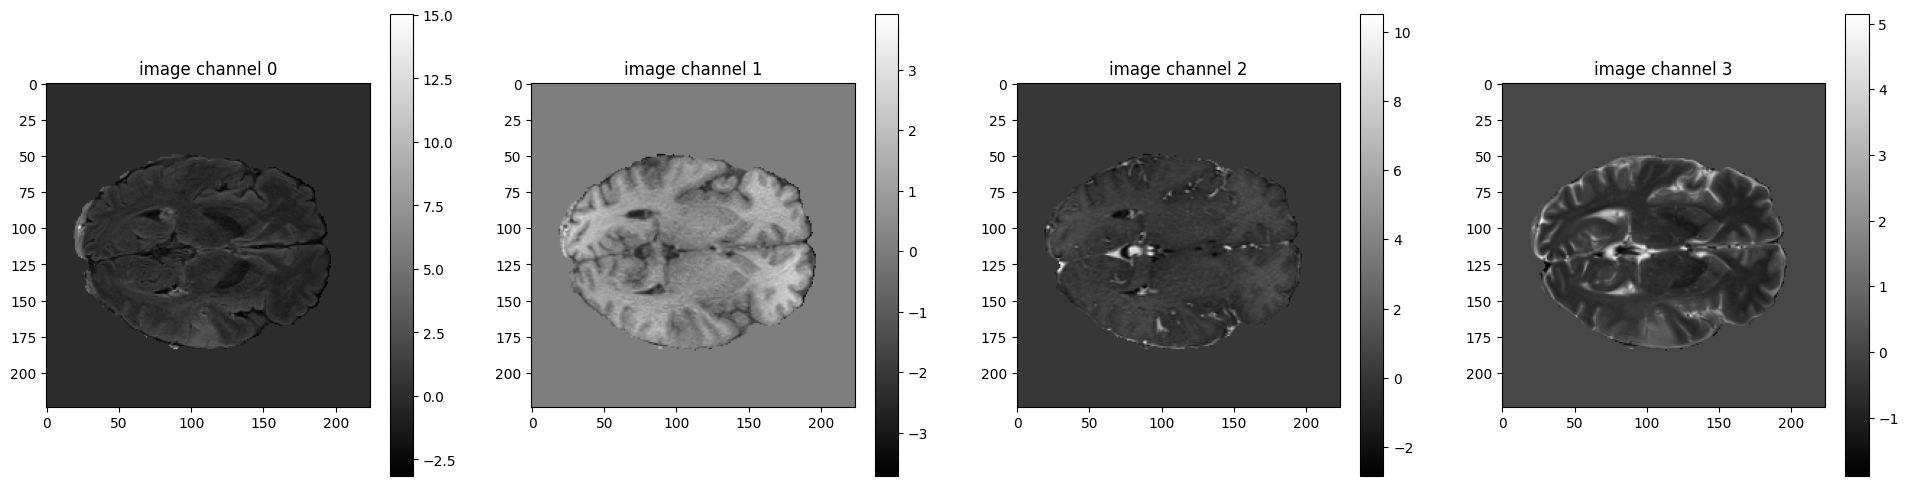

In [78]:
from monai.transforms import (
    RandCoarseDropoutD,
)

class RandomDropd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            drop_indices = generate_boolean_list()
            if len(drop_indices):
              d[key][drop_indices] = 0
        return d

# SACHIN NOTE: Only "image", "label" are supported keys
train_ds_1.transform = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image"]),
        RandomDropd(keys=["image"]), #, prob=0.1),
        Orientationd(keys=["image"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image"],
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        # RandCoarseDropoutD(keys=["image"], holes = 2, spatial_size = (96, 96, 96), fill_value = 0, prob=1.0),
        RandSpatialCropd(keys=["image"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys=["image"], factors=0.1, prob=1.0),
        RandShiftIntensityd(keys=["image"], offsets=0.1, prob=1.0),
    ]
)

val_data_example = train_ds_1[2]['image']
print(f"image shape: {val_data_example.shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i, :, :, 60].detach().cpu(), cmap="gray")
    plt.colorbar()
plt.show()


######################################

train_ds_2.transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_data_example = train_ds_2[2]['image']
print(f"image shape: {val_data_example.shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i, :, :, 60].detach().cpu(), cmap="gray")
    plt.colorbar()
plt.show()

## Setup transforms for training and validation


In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["in_image", "out_image"]),
        EnsureChannelFirstd(keys=["in_image","out_image"]),
        EnsureTyped(keys=["in_image","out_image"]),
        RandomDropd(keys=["in_image"], prob=0.1),
        Orientationd(keys=["in_image", "out_image"], axcodes="RAS"),
        Spacingd(
            keys=["in_image", "out_image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["in_image", "out_image"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["in_image", "out_image"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["in_image", "out_image"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["in_image", "out_image"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys=["in_image", "out_image"], nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys=["in_image", "out_image"], factors=0.1, prob=1.0),
        RandShiftIntensityd(keys=["in_image", "out_image"], offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["in_image", "out_image"]),
        EnsureChannelFirstd(keys=["in_image", "out_image"]),
        EnsureTyped(keys=["in_image", "out_image"]),
        Orientationd(keys=["in_image", "out_image"], axcodes="RAS"),
        Spacingd(
            keys=["in_image", "out_image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys=["in_image", "out_image"], nonzero=True, channel_wise=True),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Consider a subset of train and validation dataset for debugging the training workflow

In [ ]:
from torch.utils.data import DataLoader, Subset

train_subs = Subset(train_ds, list(range(30)))
val_subs = Subset(val_ds, list(range(20)))

train_loader = DataLoader(train_subs, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subs, batch_size=1, shuffle=False, num_workers=2)
print(len(train_loader), len(val_loader))

## Check data shape and visualize

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
    plt.colorbar()
plt.show()

## Create Model, Loss, Optimizer

**Define a 3D Unet**

In [ ]:
from monai.networks.nets import UNet

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3, # 3D
    in_channels=4,
    out_channels=8, # we will output estimated mean and estimated std dev for all 4 image channels
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2
).to(device)

In [ ]:
def GaussianLikelihood(input_img, output_img):
    # input is 4 channel images, output is 8 channel images

    output_img_mean = output_img[:4]
    output_img_std = output_img[4:]
    cost1 = (input_img - output_img_mean)**2 / (2*output_img_std**2)

    cost2 = torch.log(output_img_std)

    return torch.sum(cost1 + cost2)





import torch.nn as nn
from monai.metrics import MSEMetric

max_epochs = 20 # 300
val_interval = 1
VAL_AMP = True

# Define the loss function
loss_function = GaussianLikelihood #nn.MSELoss()
# loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# mse_metric = DiceMetric(include_background=True, reduction="mean")
# mse_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

mse_metric = MSEMetric(reduction="mean")
mse_metric_batch = MSEMetric(reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True



In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_subs) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in val_outputs]
                mse_metric(y_pred=val_outputs, y=val_inputs)
                mse_metric_batch(y_pred=val_outputs, y=val_inputs)

            metric = mse_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = mse_metric_batch.aggregate()
            mse_metric.reset()
            mse_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean mse: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean MSE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

## Check best pytorch model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)